<a href="https://colab.research.google.com/github/dh610/Advanced-AI/blob/main/Practice2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practice2: Data Augmentation 구현하기


## 1. 문제 설명
1. Mixup 유무에 따른 모델 검증 결과 비교하기.
2. Cutmix 유무에 따른 모델 검증 결과 비교하기.
3. 조건: 주어진 노트북의 다른 hyperparameter는 변경하지 말고 data augmentation만 변경할 것. 실습 과제 제출시에 사용한 모델과 모든 로그가 담겨 있는 노트북 제출.

## 2. 목차
1. 필요한 패키지 불러오기 및 parameter 구성하기
2. CIFAR10 데이터 가져오기
3. Trainloader 이미지 살펴보기
4. ResNet 모델 정의
5. 모델 학습 및 검증 (이 섹션에 mixup, cutmix 적용하기)

## 3. 참고자료
1. (ResNet) Deep Residual Learning for Image Recognition, CVPR, 2016 [[ArXiv](https://arxiv.org/pdf/1512.03385)]
2. (*) (mixup) mixup: Beyond Empirical Risk Minimization, ICLR, 2017 [[ArXiv](https://arxiv.org/pdf/1710.09412)]
3. (**) (cutmix) CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features, ICCV, 2019 [[ArXiv](https://arxiv.org/pdf/1905.04899)]


## 1. 필요한 패키지 불러오기 및 Parameter 구성하기

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
# Seed 설정 --> 코드를 돌릴때 random값을 동일하게 해주기 위해
random.seed(10)
np.random.seed(123)

# GPU사용을 위한 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# 모델 파라미터 설정
config = {'Cifar10_stats': [[0.49139965, 0.48215845, 0.4465309],
                            [0.20220213, 0.19931543, 0.20086348]],
          'batch_size'  : 256,
          'worker'      : 2,
          'epochs'      : 50,
          'momentum'    : 0.9,
          'wd_decay'    : 0.0005,
          'Adam_lr'     : 0.0005,
          }

cuda


## 2. CIFAR10 데이터 가져오기
CIFAR10의 정규화를 위해 직접 CIFAR10 데이터의 평균과 표준편차를 구해서 Train/Test 데이터셋에 정규화를 적용한다.

In [2]:
trainset = torchvision.datasets.CIFAR10(root='./data', train = True, download = True, transform = transforms.ToTensor())
testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transforms.ToTensor())
print(f"Trainset 개수: {len(trainset)}, Testset 개수: {len(testset)}")

100%|██████████| 170498071/170498071 [00:19<00:00, 8923681.73it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Trainset 개수: 50000, Testset 개수: 10000


In [3]:
# To normalize the dataset, calculate the mean and std
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in trainset]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in trainset]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])
train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])

In [4]:
print("CIFAR10_MEAN:",train_meanR, train_meanG, train_meanB) # Cifar10_stats -> mean
print("CIFAR10_STD:",train_stdR, train_stdG, train_stdB) # Cifar10_stats-> std

CIFAR10_MEAN: 0.49139965 0.48215845 0.4465309
CIFAR10_STD: 0.20220213 0.19931543 0.20086348


In [5]:
train_transforms = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomCrop(128, padding=16),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*config['Cifar10_stats']), # mean = Cifar10_stats[0], std = Cifar10_stats[1]
])

test_transforms = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(*config['Cifar10_stats']), # mean = Cifar10_stats[0], std = Cifar10_stats[1]
])

# apply transform
trainset.transform = train_transforms
testset.transform = test_transforms

# Data Loader
trainloader = DataLoader(trainset, batch_size = config['batch_size'], shuffle = True, num_workers = config['worker'])
testloader = DataLoader(testset, batch_size = config['batch_size'], shuffle = False, num_workers = config['worker'])

# Class_name 저장
with open('./data/cifar-10-batches-py/batches.meta', 'rb') as f:
    batches_meta = pickle.load(f, encoding = 'latin1')
classes_name = list(batches_meta[sorted(list(batches_meta.keys()))[0]]) # airplane, automobile, ..., truck
print(classes_name)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## 3. trainloader 이미지 살펴보기

CIFAR10데이터 가져오기에서 만든 trainloader에 이미지가 어떻게 저장되어있는지 이미지와 라벨을 같이 확인해본다.

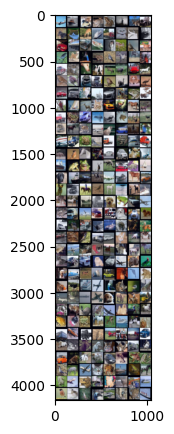

1: airplane	2: ship  	3: dog  	4: cat  	5: frog  	6: deer  	7: deer  	8: truck
9: dog  	10: cat  	11: deer  	12: ship  	13: truck  	14: cat  	15: airplane	16: cat
17: automobile	18: truck  	19: automobile	20: ship  	21: cat  	22: deer  	23: bird  	24: horse
25: bird  	26: dog  	27: bird  	28: frog  	29: bird  	30: horse  	31: deer  	32: bird
33: truck  	34: cat  	35: dog  	36: dog  	37: horse  	38: deer  	39: automobile	40: horse
41: bird  	42: bird  	43: frog  	44: truck  	45: bird  	46: bird  	47: cat  	48: bird
49: automobile	50: airplane	51: cat  	52: ship  	53: automobile	54: deer  	55: frog  	56: deer
57: bird  	58: ship  	59: deer  	60: cat  	61: automobile	62: deer  	63: horse  	64: deer
65: truck  	66: frog  	67: automobile	68: airplane	69: airplane	70: frog  	71: deer  	72: dog
73: cat  	74: horse  	75: deer  	76: airplane	77: cat  	78: truck  	79: horse  	80: bird
81: ship  	82: automobile	83: frog  	84: bird  	85: truck  	86: frog  	87: ship  	88: truck
89: bird  	90: bird 

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# trainloader의 이미지 확인
dataiter = iter(trainloader)
images, labels = next(dataiter)
fig = plt.figure(figsize = (15, 5), dpi = 100)
ax = fig.add_subplot(1,1,1)
ax.imshow(torchvision.utils.make_grid(images, normalize = True).permute(1, 2, 0))
plt.show()

# 해당 이미지의 label확인
for i in range(len(images)):
    if (i+1)%8==0:
        print(f'{i+1}: {classes_name[labels[i]]}', end = '\n')
    else:
        if len(classes_name[labels[i]]) >= 6:
            print(f'{i+1}: {classes_name[labels[i]]}', end = '\t')
        else:
            print(f'{i+1}: {classes_name[labels[i]]}', end = '  \t')

## 4. 모델 정의

In [7]:
class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size = 3, padding = 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size = 1, bias = False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.relu = nn.ReLU()
        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride = stride, kernel_size = 1, bias = False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=10):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def ResNet18():
    return ResNet(BottleNeck, [2, 2, 2, 2])

## 5. 모델 학습 및 검증

In [8]:
def mixup(x, y, num_classes=10):
    lam = np.random.rand()
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    mixed_y = lam * y + (1 - lam) * y[index]
    mixed_y = torch.round(mixed_y).long()

    return mixed_x, mixed_y

def cutmix(x, y, num_classes=10):
    lam = np.random.rand()
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    size = x.size()
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W*cut_rat)
    cut_h = int(H*cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]
    mixed_y = lam * y + (1 - lam) * y[index]
    mixed_y = torch.round(mixed_y).long()

    return x, mixed_y

for augmentation in ['none', 'mixup', 'cutmix']:
    model = ResNet18().to(device)
    model = model.to(memory_format=torch.channels_last)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(params=model.parameters(), lr = config['Adam_lr'], weight_decay=config['wd_decay'])
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, config['Adam_lr'], total_steps=config['epochs'] * len(trainloader))

    for epoch in range(config['epochs']):  # loop over the dataset multiple times

        running_loss = 0.0
        start_time = time.time()
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            inputs = inputs.to(memory_format=torch.channels_last)

            if augmentation == 'none':
                pass
            elif augmentation == 'mixup':
                inputs, labels = mixup(inputs, labels)
            elif augmentation == 'cutmix':
                inputs, labels = cutmix(inputs, labels)
            else:
                raise Exception(f'{augmentation} is not supported yet')

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            with torch.cuda.amp.autocast(True):
                output = model(inputs)

            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()

            #Time
            end_time = time.time()
            time_taken = end_time - start_time
            time_taken = str(time_taken/60).split('.')

        print('Epoch: {}/{}, train_loss: {:.4f}, time:{}m {}s'.format(epoch + 1, config['epochs'], running_loss / len(trainset), time_taken[0], time_taken[1][:2]))

    print(f'Finished Training of ResNet18 with {augmentation} augmentation')

    #Testing Accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the ResNet18 with {augmentation} on the 10000 test images: {100 * correct / total:.2f}%')

<ipython-input-8-56d174d16d2c>:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(True):


Epoch: 1/50, train_loss: 0.0072, time:0m 43s
Epoch: 2/50, train_loss: 0.0055, time:0m 40s
Epoch: 3/50, train_loss: 0.0048, time:0m 40s
Epoch: 4/50, train_loss: 0.0042, time:0m 40s
Epoch: 5/50, train_loss: 0.0038, time:0m 40s
Epoch: 6/50, train_loss: 0.0034, time:0m 40s
Epoch: 7/50, train_loss: 0.0030, time:0m 40s
Epoch: 8/50, train_loss: 0.0027, time:0m 40s
Epoch: 9/50, train_loss: 0.0024, time:0m 40s
Epoch: 10/50, train_loss: 0.0023, time:0m 40s
Epoch: 11/50, train_loss: 0.0021, time:0m 40s
Epoch: 12/50, train_loss: 0.0020, time:0m 40s
Epoch: 13/50, train_loss: 0.0018, time:0m 40s
Epoch: 14/50, train_loss: 0.0017, time:0m 40s
Epoch: 15/50, train_loss: 0.0016, time:0m 40s
Epoch: 16/50, train_loss: 0.0015, time:0m 40s
Epoch: 17/50, train_loss: 0.0014, time:0m 40s
Epoch: 18/50, train_loss: 0.0014, time:0m 40s
Epoch: 19/50, train_loss: 0.0013, time:0m 40s
Epoch: 20/50, train_loss: 0.0012, time:0m 40s
Epoch: 21/50, train_loss: 0.0011, time:0m 41s
Epoch: 22/50, train_loss: 0.0011, time:0m 4